As with all notebooks, we start with importing several Python libraries and verifying our file location:

In [1]:
#Import related modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import requests

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [2]:
# Read csv file using chunks and add CO-specific rows into a new dataframe\n",
file = 'SBAnational.csv'

sba_reader = pd.read_csv(file, chunksize=5000)

co_data = pd.DataFrame()

for sba_chunk in sba_reader:
    sba_add = sba_chunk[sba_chunk['State'] == 'CO']
    co_data = co_data.append(sba_add)
    
nRow, nCol = co_data.shape
print(f'There are {nRow} rows and {nCol} columns')
   

There are 20605 rows and 27 columns


In [29]:
print(co_data['MIS_Status'].value_counts())

P I F     16655
CHGOFF     3508
Name: MIS_Status, dtype: int64


Overall this data set is not balanced, with way more "Paid In Full" loans than not, but that of course is reality. A 4.5:1 ratio should be acceptable for many machine learning techniques. 
Next, we look at the number of loans per year, to explore how well spread out the loans are in the full time span of the data set, which is roughly 5.5 decades:

In [30]:
loan_years = pd.DataFrame(co_data['ApprovalFY'].value_counts())
loan_years['Year'] = loan_years.index
loan_years['Year'] = pd.to_numeric(loan_years['Year'])
loan_years = loan_years.sort_values('Year', ascending=False)
loan_years.head()

,ApprovalFY,Year
2014,4,2014
2013,64,2013
2012,134,2012
2011,307,2011
2010,420,2010


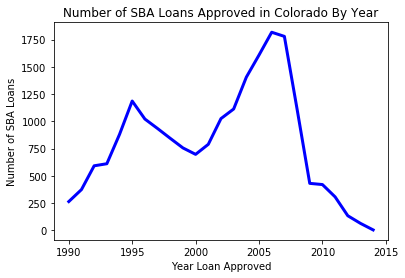

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loan_years['Year'], loan_years['ApprovalFY'], color='blue', linewidth=3)
plt.xlabel('Year Loan Approved')
plt.ylabel('Number of SBA Loans')
plt.title('Number of SBA Loans Approved in Colorado By Year')
plt.show()

Fortunately the data seems to be concentrated within a roughly 20 year time frame, from 1990 to 2010. With this observation, loans from prior to 1990 are dropped from the dataset:

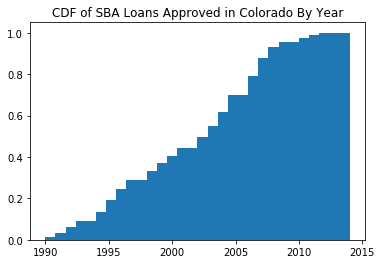

In [32]:
co_data['ApprovalFY'] = pd.to_numeric(co_data['ApprovalFY'])
plt.hist(co_data['ApprovalFY'], bins=30, cumulative=True, density=True)
plt.title('CDF of SBA Loans Approved in Colorado By Year')
plt.show()

This CDF is good news, and we can safely eliminate all years prior to 1990 from the dataset. Two decades still covers a lot of history, though: 9/11, the dotcom crash, the 2008 recession, among other things.

In [33]:
# Based on this, we can eliminate all loan data prior to 1990:

co_data = co_data[co_data.ApprovalFY >= 1990]

In [34]:
co_data.describe().T

,count,mean,std,min,25%,50%,75%,max
LoanNr_ChkDgt,20168.0,4.996296e+09,2.577563e+09,1.000786e+09,2.679085e+09,4.654488e+09,7.345299e+09,9.994893e+09
Zip,20168.0,8.041639e+04,2.578269e+03,0.000000e+00,8.012700e+04,8.024100e+04,8.090300e+04,9.999900e+04
NAICS,20168.0,4.008112e+05,2.613967e+05,0.000000e+00,2.359300e+05,4.453100e+05,5.617300e+05,9.241100e+05
ApprovalFY,20168.0,2.001512e+03,5.522194e+00,1.990000e+03,1.997000e+03,2.003000e+03,2.006000e+03,2.014000e+03
Term,20168.0,1.246146e+02,8.499696e+01,0.000000e+00,6.600000e+01,8.400000e+01,1.800000e+02,3.720000e+02
NoEmp,20168.0,1.068391e+01,4.127613e+01,0.000000e+00,2.000000e+00,4.000000e+00,1.100000e+01,4.847000e+03
NewExist,20166.0,1.230884e+00,4.234044e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
CreateJob,20168.0,2.379264e+00,1.175408e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+03
RetainedJob,20168.0,4.703094e+00,2.972966e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,3.860000e+03
FranchiseCode,20168.0,2.776310e+03,1.267445e+04,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.125300e+04


In [35]:
co_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20168 entries, 71 to 899122
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoanNr_ChkDgt      20168 non-null  int64  
 1   Name               20168 non-null  object 
 2   City               20168 non-null  object 
 3   State              20168 non-null  object 
 4   Zip                20168 non-null  int64  
 5   Bank               20147 non-null  object 
 6   BankState          20147 non-null  object 
 7   NAICS              20168 non-null  int64  
 8   ApprovalDate       20168 non-null  object 
 9   ApprovalFY         20168 non-null  int64  
 10  Term               20168 non-null  int64  
 11  NoEmp              20168 non-null  int64  
 12  NewExist           20166 non-null  float64
 13  CreateJob          20168 non-null  int64  
 14  RetainedJob        20168 non-null  int64  
 15  FranchiseCode      20168 non-null  int64  
 16  UrbanRural         2

One question that arises is if the good/bad ratio is relatively constant over time, or if there are significant changes in pass fail rate as a function of time. For example, as can be seen below, a significant increase in loan defaults occurs for loans originated in the ~2007 time frame:

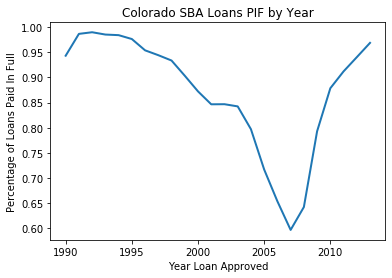

In [36]:
approved = pd.DataFrame()

for yr in range(1975,2014):
    data = co_data[co_data['ApprovalFY'] == yr]
    good = data['MIS_Status'].value_counts('P I F')
#    approved[yr] = good[0]
    approved = approved.append(good)
    
    
approved.index = range(1975,2014)
#approved.tail(10)

plt.plot(approved['P I F'], linewidth = 2.0)
plt.xlabel('Year Loan Approved')
plt.ylabel('Percentage of Loans Paid In Full')
plt.title('Colorado SBA Loans PIF by Year')
plt.show()

Next step is to fold in the information for counties, since most of the GoCode Colorado data is provided by county, and county is a nice, fairly small scale refinement of the dataset. There are 63 counties in Colorado. These are pulled from a us cities CSV file. This city list does not include every single city within Colorado, but the vast majority. Hence there may a slight reduction in dataset size after inner joining this dataset to the loan dataset. Lastly, with the 'County_FIPS' column, we now have both numerical and string indices for the 63 counties, either can be ised for merging future datasets. 

In [37]:
# Preparation of county listing by city name or county fips code
# fips codes are used in a large number of GoCode Colorado files so may be a useful column to add. 

county_file = 'uscities.csv'

county = pd.read_csv(county_file, usecols= ['city','state_id','county_fips','county_name'])
county = county[county['state_id']== 'CO'].reset_index(drop=True)
county.columns = county.columns.str.title()
county.head()


,City,State_Id,County_Fips,County_Name
0,Sanford,CO,8021,Conejos
1,Aurora,CO,8001,Adams
2,Avondale,CO,8101,Pueblo
3,Alpine,CO,8105,Rio Grande
4,Pitkin,CO,8051,Gunnison


In [38]:
# Change the 'City' column to the title string format to match the county dataframe.

co_data['City'] = co_data['City'].str.title()
co_data.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
899050,9993603007,"PRECISION GAGE, INC. & CHARLES",Thornton,CO,80241,WELLS FARGO BANK NATL ASSOC,CO,0,27-Feb-97,1997,...,0,N,NaN,30-Apr-97,"$150,000.00",$0.00,P I F,$0.00,"$150,000.00","$112,500.00"
899079,9994053010,THE HIDEOUT,Parachute,CO,81635,"BUSINESS LOAN CENTER, LLC",SC,722410,27-Feb-97,1997,...,0,N,NaN,30-Apr-97,"$200,000.00",$0.00,P I F,$0.00,"$200,000.00","$150,000.00"
899118,9994833008,WEST END RENTAL,Kremmling,CO,80459,PEOPLES NATIONAL BANK,CO,0,27-Feb-97,1997,...,N,Y,NaN,31-Jul-97,"$63,000.00",$0.00,P I F,$0.00,"$63,000.00","$50,400.00"
899119,9994843000,"FRONT RANGE DRYWALL,INC.",Denver,CO,80216,COBIZ BANK,CO,235420,27-Feb-97,1997,...,N,Y,NaN,31-May-97,"$100,000.00",$0.00,P I F,$0.00,"$100,000.00","$80,000.00"
899122,9994893004,"TRIOS ENTERPRISES,INC.",Fort Collins,CO,80526,FIRST NATIONAL BANK OF OMAHA,NE,0,27-Feb-97,1997,...,N,Y,NaN,31-Mar-98,"$93,600.00",$0.00,P I F,$0.00,"$93,600.00","$74,880.00"


Inner join merge reduces the dataset from 20168 to 19372 rows, or about 4% reduction, which is acceptable. The merged dataframe is now ready to accept additional data based on county and year.

In [39]:
df = pd.merge(co_data, county, how = 'inner', on = 'City')
df.shape

(19372, 30)

In [40]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,State_Id,County_Fips,County_Name
0,1000786003,MICHAEL GADEKEN DDS PC,Grand Junction,CO,81506,WELLS FARGO BANK NATL ASSOC,SD,621210,7-Feb-06,2006,...,31-Mar-06,"$1,524,200.00",$0.00,P I F,$0.00,"$1,535,000.00","$1,151,250.00",CO,8077,Mesa
1,1018664008,"MINE TECHNOLOGIES,INC.",Grand Junction,CO,81506,ANB BANK,CO,333131,7-Mar-97,1997,...,31-May-97,"$90,000.00",$0.00,P I F,$0.00,"$90,000.00","$72,000.00",CO,8077,Mesa
2,1035774008,"CRAIG M. DROSKIN, D.D.S.",Grand Junction,CO,81501,WELLS FARGO BANK NATL ASSOC,SD,621210,14-Mar-97,1997,...,30-Apr-97,"$59,000.00",$0.00,P I F,$0.00,"$59,000.00","$47,200.00",CO,8077,Mesa
3,1089555003,Johnny R. Webb II DBA Webb's A,Grand Junction,CO,81501,CAPITAL ONE NATL ASSOC,VA,811111,25-Oct-04,2005,...,31-Jan-05,"$50,000.00",$0.00,CHGOFF,"$28,061.00","$50,000.00","$25,000.00",CO,8077,Mesa
4,1135084010,THE DONUT SHOP PLUS,Grand Junction,CO,81504,ANB BANK,CO,0,16-Apr-97,1997,...,31-May-97,"$21,200.00",$0.00,P I F,$0.00,"$21,200.00","$16,960.00",CO,8077,Mesa


We can see that the dataset is fairly heavy on a handful of counties. This makes sense, as the counties with many loans (e.g. Denver, Arapahoe, Boulder) are much higher in population. 

In [41]:
county_counts = df['County_Name'].value_counts()

county_counts.columns = ['NumLoans']
county_counts.head(20)

Denver        3647
Arapahoe      2046
El Paso       1977
Adams         1929
Jefferson     1556
Boulder       1380
Larimer       1078
Douglas        805
Weld           506
Mesa           445
Pueblo         434
La Plata       348
Broomfield     310
Eagle          293
Summit         282
Garfield       249
Montrose       156
Montezuma      149
Delta          137
Gunnison       133
Name: County_Name, dtype: int64

In [42]:
goodrate = pd.Series()

for i in range(0,63):
    c = county_counts.index[i]
    goodrate[c] = df[df['County_Name'] == c]['MIS_Status'].value_counts('P I F')[0]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Next, I want to explore the county by county variation in loan performance, using a dataframe called county_rates. A histogram of the overall percentage of repaid loans by county shows some spread in values, suggesting that how likely a loan is to be paid off may be partially a function of location in Colorado:

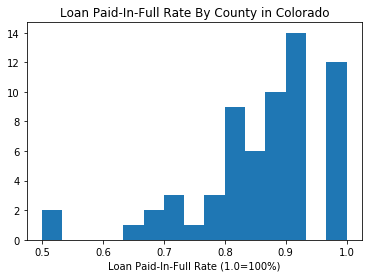

In [43]:
plt.hist(goodrate, bins=15)
plt.title('Loan Paid-In-Full Rate By County in Colorado')
plt.xlabel('Loan Paid-In-Full Rate (1.0=100%)')
plt.show()

In [44]:
goodrate['County'] = goodrate.index
county_counts['County'] = county_counts.index

In [45]:
county_rates = pd.concat([county_counts, goodrate], axis=1)

county_rates.columns = ['TotalLoansInCounty','PIF_RateByCounty']
county_rates['County_Name'] = county_rates.index

In [48]:
county_rates.head()

,TotalLoansInCounty,PIF_RateByCounty,County_Name
Denver,3647,0.839232,Denver
Arapahoe,2046,0.797654,Arapahoe
El Paso,1977,0.819838,El Paso
Adams,1929,0.752722,Adams
Jefferson,1556,0.821979,Jefferson


In [49]:
# Add the loan repayment rate and number of loans per county data to the dataframe df:

df = pd.merge(df, county_rates, how = 'left', on = 'County_Name')

In [51]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,State_Id,County_Fips,County_Name,TotalLoansInCounty,PIF_RateByCounty
0,1000786003,MICHAEL GADEKEN DDS PC,Grand Junction,CO,81506,WELLS FARGO BANK NATL ASSOC,SD,621210,7-Feb-06,2006,...,$0.00,P I F,$0.00,"$1,535,000.00","$1,151,250.00",CO,8077,Mesa,445,0.876404
1,1018664008,"MINE TECHNOLOGIES,INC.",Grand Junction,CO,81506,ANB BANK,CO,333131,7-Mar-97,1997,...,$0.00,P I F,$0.00,"$90,000.00","$72,000.00",CO,8077,Mesa,445,0.876404
2,1035774008,"CRAIG M. DROSKIN, D.D.S.",Grand Junction,CO,81501,WELLS FARGO BANK NATL ASSOC,SD,621210,14-Mar-97,1997,...,$0.00,P I F,$0.00,"$59,000.00","$47,200.00",CO,8077,Mesa,445,0.876404
3,1089555003,Johnny R. Webb II DBA Webb's A,Grand Junction,CO,81501,CAPITAL ONE NATL ASSOC,VA,811111,25-Oct-04,2005,...,$0.00,CHGOFF,"$28,061.00","$50,000.00","$25,000.00",CO,8077,Mesa,445,0.876404
4,1135084010,THE DONUT SHOP PLUS,Grand Junction,CO,81504,ANB BANK,CO,0,16-Apr-97,1997,...,$0.00,P I F,$0.00,"$21,200.00","$16,960.00",CO,8077,Mesa,445,0.876404


Now turning to the Personal income dataset from GoCode Colorado, to fold into the County dataset:

In [52]:
# Personal income dataset from GoCode Colorado

file1 = 'Personal_income_in_Colorado.csv'

income = pd.read_csv(file1, usecols=['areaname', 'periodyear', 'incdesc', 'income','population' ])

# Wrangle and tidy dataset for use:

income = income[income['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
income = income[income['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
income = income[income['incdesc'].str.startswith('Per')]      # <------ Discard Total and Median values (only per cap)

income.head()


,areaname,periodyear,incdesc,income,population
394,Adams County,1990,Per Capita Personal Income - Bureau of Economi...,16192,266629.0
397,Adams County,1991,Per Capita Personal Income - Bureau of Economi...,16647,274311.0
399,Adams County,1992,Per Capita Personal Income - Bureau of Economi...,17538,284362.0
401,Adams County,1993,Per Capita Personal Income - Bureau of Economi...,18393,293995.0
404,Adams County,1994,Per Capita Personal Income - Bureau of Economi...,19262,302197.0


A little cleanup of column information in the reduced dataframe. Remove the "County" in areaname, shorten the incdesc column string, and rename columns to better names and a Title format.

In [53]:
income['areaname'] = income['areaname'].str.replace(' County', '')
income = income.drop(columns = ['incdesc'])
income.columns = ['County', 'Year', 'MedianInc', 'Population']
income.reset_index()
income.head()

,County,Year,MedianInc,Population
394,Adams,1990,16192,266629.0
397,Adams,1991,16647,274311.0
399,Adams,1992,17538,284362.0
401,Adams,1993,18393,293995.0
404,Adams,1994,19262,302197.0


Aggregating this dataframe to look at the maximum (of the Median) Per Capita Personal income across all counties in Colorado shows a significant spread:

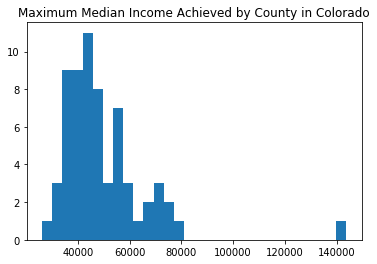

In [55]:
maxPC = income.groupby(by = 'County').agg(max)
plt.hist(maxPC['MedianInc'], bins=30)
plt.title('Maximum Median Income Achieved by County in Colorado')
plt.show()

Since we have median income and population data for all years in this dataframe, will be interesting to look at how those numbers have shifted for different counties. Next we want to aggregate the data with a calculation for how much the population in each county has increased over a given time period. Here, we will say from 1995 to 2010:

In [56]:
# Years can be modified here if needed in future. Year 1 is beginning year and year 2 is ending year
year1 = 1995
year2 = 2010

df1 = income.loc[income['Year'] == year1].reset_index()
df2 = income.loc[income['Year'] == year2].reset_index()


In [59]:
dif = pd.DataFrame()

dif['County'] = df1['County']

dif['PopChange'] = (df2['Population'].subtract(df1['Population'])) / df2['Population']
dif.head()

,County,PopChange
0,Adams,0.293547
1,Alamosa,0.097576
2,Arapahoe,0.222551
3,Archuleta,0.411248
4,Baca,-0.188918


The histogram below shows how the population of each county has changed from year 1 to year 2, normalized by the population in year 2 (2010). 

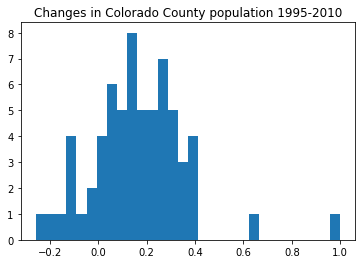

In [60]:
plt.hist(dif['PopChange'], bins=30)
plt.title('Changes in Colorado County population 1995-2010')
plt.show()

In [61]:
income = pd.merge(income, dif, how = 'left', on = 'County')

In [62]:
income.head()

,County,Year,MedianInc,Population,PopChange
0,Adams,1990,16192,266629.0,0.293547
1,Adams,1991,16647,274311.0,0.293547
2,Adams,1992,17538,284362.0,0.293547
3,Adams,1993,18393,293995.0,0.293547
4,Adams,1994,19262,302197.0,0.293547


Now we want to merge the new income dataframe into the loans dataframe based on both year and county:

In [64]:
df = pd.merge(df, income, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

In [65]:
df.tail(10)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,State_Id,County_Fips,County_Name,TotalLoansInCounty,PIF_RateByCounty,County,Year,MedianInc,Population,PopChange
19362,8590963000,LEONARD'S WELDING & MFG.,Lewis,CO,81327,"FIRST NATIONAL BANK, CORTEZ",CO,235910,14-Aug-95,1995,...,CO,8083,Montezuma,149,0.90604,Montezuma,1995,18501,22035.0,0.137506
19363,8946973005,ROUND-UP JUNCTION RESTAURANT,Lewis,CO,81327,"FIRST NATIONAL BANK, CORTEZ",CO,0,19-Jan-96,1996,...,CO,8083,Montezuma,149,0.90604,Montezuma,1996,18858,22588.0,0.137506
19364,7988883006,RAGAN TRUCKING,Howard,CO,81233,WELLS FARGO BANK NATL ASSOC,CO,0,17-Jan-95,1995,...,CO,8043,Fremont,26,0.923077,Fremont,1995,15410,41239.0,0.119897
19365,8058954008,SIDEWALK CAFE,Ovid,CO,80744,BBCN BANK,CA,722110,5-Nov-04,2005,...,CO,8115,Sedgwick,16,0.8125,Sedgwick,2005,30349,2522.0,-0.132068
19366,8561153005,HIGHLAND LUMBER CO.,Tabernash,CO,80478,BANK OF THE WEST,CO,0,2-Aug-95,1995,...,CO,8049,Grand,112,0.928571,Grand,1995,22040,9944.0,0.327335
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,CO,8059,Jefferson,1556,0.821979,Jefferson,2005,41754,519675.0,0.081159
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,CO,8109,Saguache,12,1,Saguache,1996,15121,5413.0,0.152379
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,CO,8021,Conejos,8,1,Conejos,1996,13819,7995.0,0.048722
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,CO,8099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,CO,8099,Prowers,15,0.8,Prowers,1996,18021,14046.0,-0.110333


Next, we add labor department data for employment and unemployment as a function of county and year:

In [72]:
file_unemp = 'Unemployment_Estimates_in_Colorado.csv'

employ = pd.read_csv(file_unemp, usecols=['areaname', 'periodyear', 'pertypdesc','laborforce', 'emplab','unemp','unemprate' ])
#employ = pd.read_csv(file_unemp)

# Wrangle and tidy dataset for use:

employ = employ[employ['areaname'].str.endswith('County')]    # <------ Discard all non-county rows
employ = employ[employ['periodyear'] >= 1990]                 # <------ Discard all dates prior to 1990
employ = employ[employ['pertypdesc'] == 'Annual']             # <------ Discard all monthly data


employ.head(15)

,areaname,periodyear,pertypdesc,laborforce,emplab,unemp,unemprate
711,Adams County,1990,Annual,140544,132385,8159,5.8
724,Adams County,1991,Annual,142002,134516,7486,5.3
737,Adams County,1992,Annual,145671,137195,8476,5.8
750,Adams County,1993,Annual,150890,142831,8059,5.3
763,Adams County,1994,Annual,158763,151849,6914,4.4
776,Adams County,1995,Annual,165592,159031,6561,4.0
789,Adams County,1996,Annual,167915,160800,7115,4.2
802,Adams County,1997,Annual,172650,166897,5753,3.3
815,Adams County,1998,Annual,180916,174701,6215,3.4
828,Adams County,1999,Annual,183841,178606,5235,2.8


In [73]:
employ['areaname'] = employ['areaname'].str.replace(' County', '')
employ = employ.drop(columns = ['pertypdesc'])
employ.columns = ['County', 'Year', 'LaborForceInCty', 'EmployedInCty','UnempInCty','UnempRateInCty']
employ.reset_index()

,index,County,Year,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty
0,711,Adams,1990,140544,132385,8159,5.8
1,724,Adams,1991,142002,134516,7486,5.3
2,737,Adams,1992,145671,137195,8476,5.8
3,750,Adams,1993,150890,142831,8059,5.3
4,763,Adams,1994,158763,151849,6914,4.4
...,...,...,...,...,...,...,...
1915,32806,Elbert,2018,15034,14628,406,2.7
1916,32841,Lake,2016,4613,4481,132,2.9
1917,32877,Kit Carson,2016,4534,4438,96,2.1
1918,32902,Baca,2019,2175,2138,37,1.7


In [74]:
df = pd.merge(df, employ, how = 'left', left_on=['County_Name','ApprovalFY'], right_on=['County','Year'])

In [75]:
df.tail()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,Year_x,MedianInc,Population,PopChange,County_y,Year_y,LaborForceInCty,EmployedInCty,UnempInCty,UnempRateInCty
19367,8771344008,DAHL-HOUSE CONSTRUCTION,Indian Hills,CO,80454,U.S. BANK NATIONAL ASSOCIATION,OH,238110,7-Apr-05,2005,...,2005,41754,519675.0,0.081159,Jefferson,2005,304514,289606,14908,4.9
19368,8955463007,CRYSTAL STIX,Moffat,CO,81143,VECTRA BK COLORADO NATL ASSOC,NM,339920,24-Jan-96,1996,...,1996,15121,5413.0,0.152379,Saguache,1996,2783,2463,320,11.5
19369,9253773006,ROMEO LIQUORS,Romeo,CO,81148,VECTRA BK COLORADO NATL ASSOC,NM,445310,6-May-96,1996,...,1996,13819,7995.0,0.048722,Conejos,1996,3699,3375,324,8.8
19370,9497963000,SKC ACCOUNTING SERVICES,Holly,CO,81047,VALLEY NATL BANK A BRANCH OF,CO,0,29-Aug-96,1996,...,1996,18021,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2
19371,9597073001,"TINY'S COUNTRY STORE, INC.",Granada,CO,81041,SCEDD DEVELOPMENT COMPANY,CO,0,30-Sep-96,1996,...,1996,18021,14046.0,-0.110333,Prowers,1996,6615,6335,280,4.2


Down here I will start to work with chloropleths to make some colored map graphics for some of the data (work in progress):

In [ ]:
county_json = 'https://github.com/deldersveld/topojson/blob/master/countries/us-states/CO-08-colorado-counties.json'

from urllib.request import urlopen
import json
with urlopen(county_json) as response:
    counties = json.load(response)

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

In [ ]:
import plotly.express as px